In [136]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

key_size = 16
plain_text_size = 16
batch_size = 4096
batches_per_epoch = 4
eve_multiplier = 2
display_step = 20
seed = 42

In [141]:
def generator():
  while True:
    plain_texts = tf.random.uniform(shape = (batch_size, plain_text_size), minval = 0, maxval = 2, seed = seed, dtype = tf.dtypes.int32)
    plain_texts = plain_texts * 2 - 1
    plain_texts = tf.cast(plain_texts, tf.dtypes.float32)
    keys = tf.random.uniform(shape = (batch_size, key_size), minval = 0, maxval = 2, seed = seed, dtype = tf.dtypes.int32)
    keys = keys * 2 - 1
    keys = tf.cast(keys, tf.dtypes.float32)
    yield [plain_texts, keys]

## EXAMPLE
train_gen = generator()
mb = next(train_gen)
print("Plaintexts")
print(mb[0].shape)
print(mb[0][0].shape)
print(mb[0][0])
print("Keys")
print(mb[1].shape)
print(mb[1][0].shape)
print(mb[1][0])
print("combined")
temp = tf.concat((mb[0], mb[1]), axis = 1)
print(temp.shape)
print(temp[0].shape)
print(temp[0])

Plaintexts
(4096, 16)
(16,)
tf.Tensor([-1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1.], shape=(16,), dtype=float32)
Keys
(4096, 16)
(16,)
tf.Tensor([-1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1.], shape=(16,), dtype=float32)
combined
(4096, 32)
(32,)
tf.Tensor(
[-1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1.  1.
 -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1.], shape=(32,), dtype=float32)


In [142]:
class crypto_gan():
  def __init__(self):
    self.alice = self.model(name = 'Alice')
    self.bob = self.model(name = 'Bob')
    self.ab_opt = Adam(learning_rate=8e-3)
    self.ab_loss = []
    
    self.eve = self.model(key = False, name = 'Eve')
    self.eve_opt = Adam(learning_rate=8e-3)
    self.eve_loss = []

  def model(self, name, key = True):
    if key:
      input_shape = (plain_text_size + key_size)
    else :
      input_shape = (plain_text_size, )
    
    input = Input(shape = (input_shape), name = 'input')
    x = Dense(units = (plain_text_size + key_size), activation = None, name = 'dense')(input)
    x = Reshape(target_shape = ( x.shape[1], 1, 1), name = 'reshape1')(x)
    x = Conv2D(filters = 2, kernel_size = (4, 1), padding = 'same', activation = 'sigmoid', name = 'conv2d_1')(x)
    x = Conv2D(filters = 4, kernel_size = (2, 1), activation = 'sigmoid', padding = 'valid', strides = 2, name = 'conv2d_2')(x)
    x = Conv2D(filters = 4, kernel_size = (1, 1), activation = 'sigmoid', padding = 'valid', name = 'conv2d_3')(x)
    x = Conv2D(filters = 1, kernel_size = (1, 1), activation = 'tanh', padding = 'valid', name = 'conv2d_4')(x)
    out = Reshape(target_shape = (plain_text_size, ), name = 'reshape2')(x)

    arch = Model(inputs = input, outputs = out, name = name)
    return arch
  
  def train(self, epochs, data_gen):
    current_step = 0
    for epoch in range(epochs):
      for batch in range(batches_per_epoch):
        a_plain_texts, keys = next(data_gen)
        
        with tf.GradientTape(persistent = True) as tape:
          
          # generate ciphertexts by A
          combined = tf.concat((a_plain_texts, keys), axis = 1)
          ciphertexts = self.alice(combined)
          
          # generate plaintext by B
          combined = tf.concat((ciphertexts, keys), axis = 1)
          b_plain_texts = self.bob(combined)
          
          # generate plaintext by E
          c_plain_texts = self.eve(ciphertexts)

          # calculate E loss over minibatch
          eve_loss = tf.reduce_sum(tf.abs((c_plain_texts + 1.0)/ 2.0 - (a_plain_texts + 1.0)/ 2.0), axis = 1)
          eve_loss_total  = tf.reduce_mean(eve_loss)
          # print(eve_loss)
          # print(eve_loss_total)
          
          # calculate AB loss over minibatch
          ab_loss1 = tf.reduce_sum(tf.abs((a_plain_texts + 1.0)/2.0 - (b_plain_texts + 1.0)/2.0), axis = 1)
          ab_loss2 = ((plain_text_size//2 - eve_loss)**2)/((plain_text_size//2)**2)
          ab_loss = ab_loss1 + ab_loss2
          ab_loss_total = tf.reduce_mean(ab_loss)
          # print(ab_loss1)
          # print(ab_loss2)
          # print(ab_loss)
          # print(ab_loss_total)

        for _ in range(eve_multiplier):
          # calcualte gradients
          eve_grads = tape.gradient(eve_loss_total, self.eve.trainable_variables)
          # apply gradients
          self.eve_opt.apply_gradients(zip(eve_grads, self.eve.trainable_variables))
        
        # calculate gradients
        ab_variables = self.alice.trainable_variables + self.bob.trainable_variables
        ab_gradients = tape.gradient(ab_loss_total, ab_variables)
        # apply gradients
        self.ab_opt.apply_gradients(zip(ab_gradients, ab_variables))
      
      # append losses
      self.eve_loss.append(eve_loss_total)
      self.ab_loss.append(ab_loss_total)
      current_step += 1
      if current_step % display_step == 0:
        print(f"Step {current_step} \nAB Loss : {ab_loss_total}\nEve loss : {eve_loss_total}")

      # delete gradient tape
      del tape

model = crypto_gan()
model.alice.summary()
model.bob.summary()
model.eve.summary()

Model: "Alice"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 reshape1 (Reshape)          (None, 32, 1, 1)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 1, 2)          10        
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 1, 4)          20        
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 1, 4)          20        
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 1, 1)          5     

In [145]:
model.train(epochs = 200, data_gen = train_gen)

Step 20 
AB Loss : 0.21461471915245056
Eve loss : 4.92531681060791
Step 40 
AB Loss : 0.13832823932170868
Eve loss : 5.932687282562256
Step 60 
AB Loss : 0.12392456084489822
Eve loss : 6.14817476272583
Step 80 
AB Loss : 0.11067245900630951
Eve loss : 6.340568542480469
Step 100 
AB Loss : 0.10333970934152603
Eve loss : 6.437292575836182


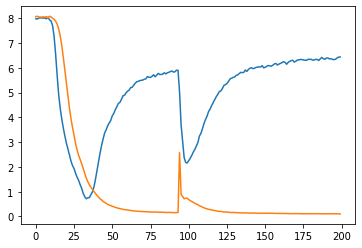

In [146]:
plt.plot(range(0, 200), model.eve_loss)
plt.plot(range(0, 200), model.ab_loss)
plt.show()